In [ ]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [ ]:
# Import Libraries
import os
import random
import torch
import evaluate
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import AdamW
from tqdm import tqdm
import torch.nn as nn
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from nltk.corpus import stopwords

In [ ]:
# Clone the repository
!git clone https://github.com/ryanzhumich/AESLC.git

Cloning into 'AESLC'...
remote: Enumerating objects: 17469, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 17469 (delta 1), reused 0 (delta 0), pack-reused 17461 (from 1)
Receiving objects: 100% (17469/17469), 7.36 MiB | 9.54 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [ ]:
def load_data_to_dataframe(folder_path):
    data = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {file_path}")

        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.read().strip().split('\n')

            email_body = []
            subject_line = None
            in_subject_section = False  # Track if we are in the `@subject` section

            for line in lines:
                # Detect subject line
                if line.startswith('@subject'):
                    in_subject_section = True
                    subject_line = line.replace('@subject', '').strip()
                elif in_subject_section and not line.startswith('@'):  # If it's part of the subject section
                    subject_line += ' ' + line.strip()
                elif line.startswith('@'):  # Stop collecting subject when other annotations start
                    in_subject_section = False
                elif not line.startswith('@'):  # Collect email body
                    email_body.append(line)

            # Debug the parsed components
            print(f"Parsed email_body: {email_body}")
            print(f"Parsed subject_line: {subject_line}")

            # Only add valid entries
            if email_body and subject_line:
                data.append({
                    'email': ' '.join(email_body).strip(),
                    'subject': subject_line.strip()
                })
            else:
                print(f"Skipped file due to missing data: {file_name}")

    print(f"Total records loaded: {len(data)}")
    return pd.DataFrame(data)

# Load datasets
train_data = load_data_to_dataframe('AESLC/enron_subject_line/train')
dev_data = load_data_to_dataframe('AESLC/enron_subject_line/dev')
test_data = load_data_to_dataframe('AESLC/enron_subject_line/test')

Streaming output truncated to the last 5000 lines.
Parsed subject_line:  UBS HR Meeting - REQUIRED 
Processing file: AESLC/enron_subject_line/test/thomas-p_inbox_132.subject
Parsed email_body: ['The Analyst and Associate Program recently began utilizing one central system for our pool information.', 'We are now in the process of verifying all pool members rotation information for reporting purposes.', 'Please respond as soon as possible with:  Your rotation end date\t   \t                               \t\t\t\t       (mm/dd/yy)  Your cost center number\t  \t                              \t   Thank you,', '', 'request for information for pool members', '', 'verify information for pool', '', 'central system for pool information']
Parsed subject_line:  Rotation Verification 
Processing file: AESLC/enron_subject_line/test/salisbury-h_inbox_941.subject
Parsed email_body: ['Please disregard previous e-mails regarding the EES Mailing List.', 'Instead of spending time typing out a lengthy dist

In [ ]:
# Display the first 3 rows of train dataset
train_data[:3]

,email,subject
0,Some EES folks just popped into my office and ...,Today's EES Meeting
1,Ettera issues: 1. When hourly is asked to ma...,Ettera
2,"Marie, I just spoke to Robert Allen and the...",Robert Allen


In [ ]:
# Display the first 5 rows of train dataset
train_data.head()

,email,subject
0,Some EES folks just popped into my office and ...,Today's EES Meeting
1,Ettera issues: 1. When hourly is asked to ma...,Ettera
2,"Marie, I just spoke to Robert Allen and the...",Robert Allen
3,I have lots of blanks on my approvals on the a...,country approvals
4,Please give me a call ASAP on marketing affili...,EComm


In [ ]:
# Display the first 5 rows of test dataset
test_data.head()

,email,subject
0,Just a note that all Michcon deals need to be...,Michcon Deals
1,"Guys, I would like to add the following commen...",AIG Fund
2,This weekend marks the first employee move int...,Enron Center South Occupancy
3,"Mike, Here's a revised version of the option ...",Option
4,We made 1 big change that will impact tonights...,New Power Volume changes


In [ ]:
# Display the first 5 rows of dev dataset
dev_data.head()

,email,subject
0,"See, bad stuff. Enron fires two employees link...",Enron fires two employees linked to partnershi...
1,"Welcome to UBS Warburg Energy, LLC All UBS Wa...",UBSW ENERGY KICK-OFF CELEBRATION
2,Hi David: Could you give me a call to discuss ...,De-regulation Project
3,see below. I'm sure your guys are considering ...,Appeal for your support to continue to serve E...
4,Please post this as a meeting material for tom...,Corrected BME-Realtime Prices


In [ ]:
# Ensure the splits have the expected sizes
print(f"Train: {len(train_data)}, Dev: {len(dev_data)}, Test: {len(test_data)}")

Train: 14436, Dev: 1960, Test: 1906


In [ ]:
# Combine all datasets without adding the split column
all_data = pd.concat([train_data, dev_data, test_data], ignore_index=True)

# Inspect the combined dataset
all_data.head()

,email,subject
0,Some EES folks just popped into my office and ...,Today's EES Meeting
1,Ettera issues: 1. When hourly is asked to ma...,Ettera
2,"Marie, I just spoke to Robert Allen and the...",Robert Allen
3,I have lots of blanks on my approvals on the a...,country approvals
4,Please give me a call ASAP on marketing affili...,EComm


In [ ]:
# General information about the dataset
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18302 entries, 0 to 18301
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   email    18302 non-null  object
 1   subject  18302 non-null  object
dtypes: object(2)
memory usage: 286.1+ KB
None


In [ ]:
# Check for missing values in all columns
print(all_data.isnull().sum())

email      0
subject    0
dtype: int64


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Clean Text
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove special characters but retain letters, numbers, and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Normalize spaces (remove extra spaces)
    text = ' '.join(text.split())

    # Remove stopwords
    # stop_words = set(stopwords.words("english"))
    # text = ' '.join(word for word in text.split() if word not in stop_words)

    return text

# Apply the updated clean_text function
all_data['email'] = all_data['email'].apply(clean_text)
all_data['subject'] = all_data['subject'].apply(clean_text)

In [ ]:
# Check the cleaned data
all_data.head()

,email,subject
0,some ees folks just popped into my office and ...,todays ees meeting
1,ettera issues 1 when hourly is asked to manage...,ettera
2,marie i just spoke to robert allen and they ar...,robert allen
3,i have lots of blanks on my approvals on the a...,country approvals
4,please give me a call asap on marketing affili...,ecomm


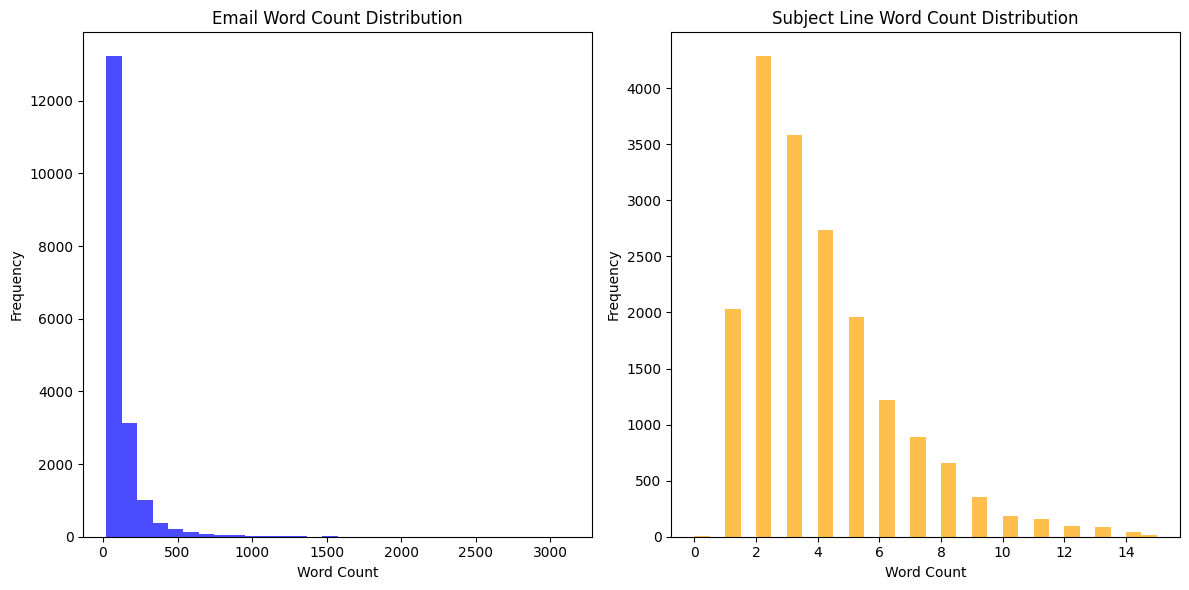

In [ ]:
# Calculate word counts
all_data['email_word_count'] = all_data['email'].apply(lambda x: len(x.split()))
all_data['subject_word_count'] = all_data['subject'].apply(lambda x: len(x.split()))

# Plot histograms
plt.figure(figsize=(12, 6))

# Email word count distribution
plt.subplot(1, 2, 1)
plt.hist(all_data['email_word_count'], bins=30, color='blue', alpha=0.7)
plt.title('Email Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Subject line word count distribution
plt.subplot(1, 2, 2)
plt.hist(all_data['subject_word_count'], bins=30, color='orange', alpha=0.7)
plt.title('Subject Line Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Correlation between email and subject line lengths
correlation = np.corrcoef(all_data['email_word_count'], all_data['subject_word_count'])[0, 1]
print(f"Correlation between email and subject line word counts: {correlation}")

Correlation between email and subject line word counts: 0.11915940625544076


In [ ]:
# Find and remove duplicates
print(f"Number of duplicate rows: {all_data.duplicated().sum()}")
all_data = all_data.drop_duplicates()

# Check for duplicates in all_data after dropping them
print(f"Number of duplicate rows: {all_data.duplicated().sum()}")

Number of duplicate rows: 889
Number of duplicate rows: 0


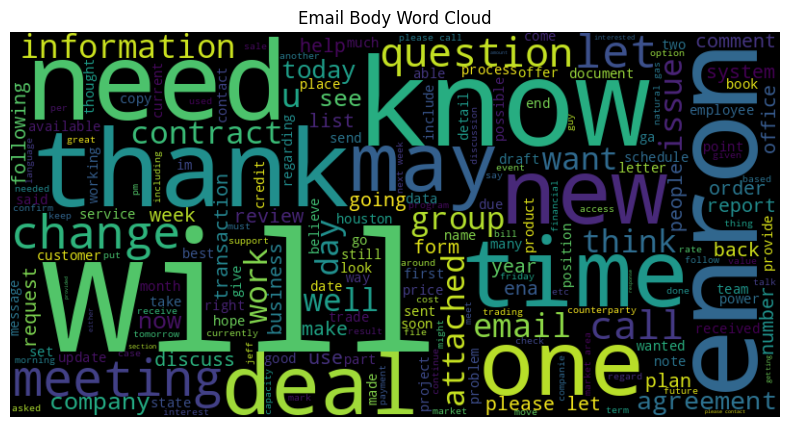

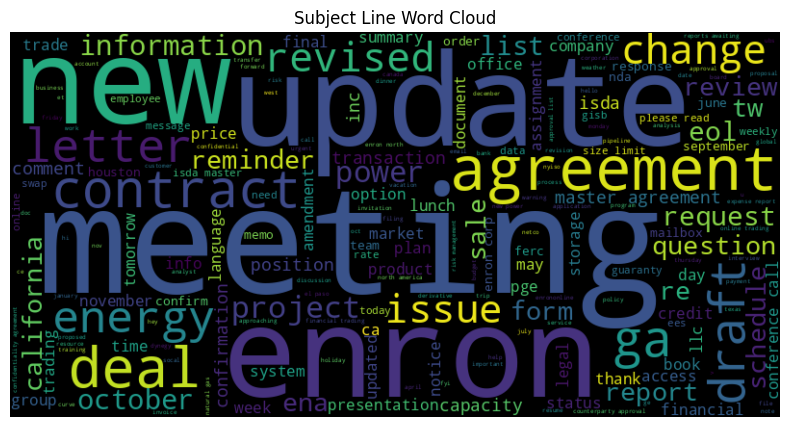

In [ ]:
# Email body word cloud
email_words = " ".join(all_data['email']).split()
email_wordcloud = WordCloud(width=800, height=400).generate(" ".join(email_words))
plt.figure(figsize=(10, 5))
plt.imshow(email_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Email Body Word Cloud')
plt.show()

# Subject line word cloud
subject_words = " ".join(all_data['subject']).split()
subject_wordcloud = WordCloud(width=800, height=400).generate(" ".join(subject_words))
plt.figure(figsize=(10, 5))
plt.imshow(subject_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Subject Line Word Cloud')
plt.show()

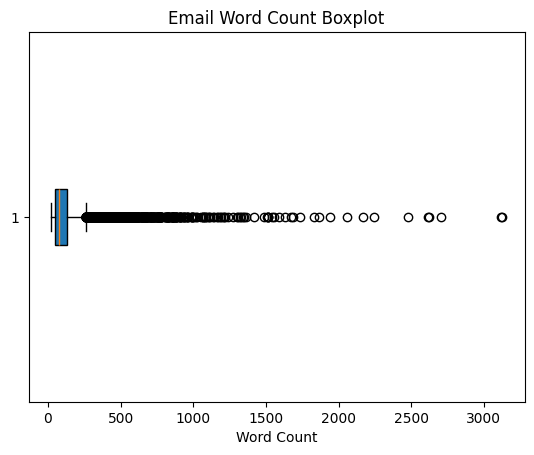

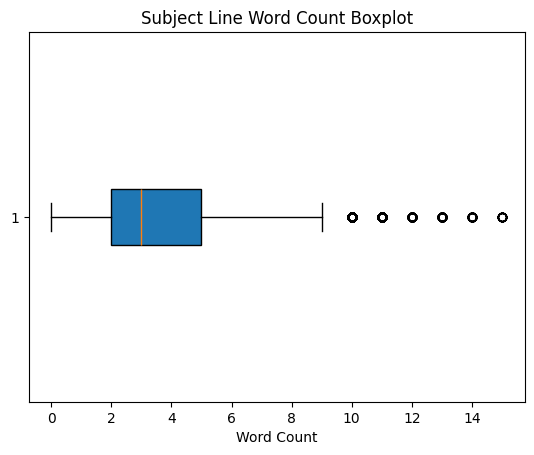

In [ ]:
# Identify outliers in email lengths or subject line lengths.
# Boxplot for email word counts
plt.boxplot(all_data['email_word_count'], vert=False, patch_artist=True)
plt.title('Email Word Count Boxplot')
plt.xlabel('Word Count')
plt.show()

# Boxplot for subject line word counts
plt.boxplot(all_data['subject_word_count'], vert=False, patch_artist=True)
plt.title('Subject Line Word Count Boxplot')
plt.xlabel('Word Count')
plt.show()

In [ ]:
# Identify outliers using InterQuartile Range(IQR)
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Identify outliers
email_outliers = identify_outliers(all_data, 'email_word_count')
subject_outliers = identify_outliers(all_data, 'subject_word_count')

print(f"Email outliers: {len(email_outliers)}")
print(f"Subject line outliers: {len(subject_outliers)}")

Email outliers: 1399
Subject line outliers: 545


In [ ]:
# Remove outliers and clean the dataset
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Cleaned dataset
cleaned_data = remove_outliers(all_data, 'email_word_count')
cleaned_data = remove_outliers(cleaned_data, 'subject_word_count')

print(f"Cleaned data size: {len(cleaned_data)}")

Cleaned data size: 15538


# T5 - SMALL

In [ ]:
# Prepare the data for model training
def prepare_data_for_training(data):
    """
    Prepares the dataset for training by formatting it into input-output pairs.
    Args:
        data (pd.DataFrame): Cleaned and preprocessed dataset.
    Returns:
        pd.DataFrame: Dataset with 'input_text' and 'target_text' columns.
    """
    # Ensure columns exist in the input data
    if 'email' not in data.columns or 'subject' not in data.columns:
        raise ValueError("Input data must contain 'email' and 'subject' columns.")

    # Combine email body with a prefix to make input text
    data['input_text'] = "summarize: " + data['email']
    data['target_text'] = data['subject']

    # Select relevant columns
    prepared_data = data[['input_text', 'target_text']]
    return prepared_data

# Split data into training, validation, and test sets
def split_data(data, train_size=0.8, random_state=42):
    """
    Splits the dataset into training, validation, and test sets.
    Args:
        data (pd.DataFrame): Dataset with 'input_text' and 'target_text' columns.
        train_size (float): Proportion of the dataset to include in the training split.
        random_state (int): Random state for reproducibility.
    Returns:
        dict: A dictionary containing 'train', 'validation', and 'test' DataFrames.
    """
    # Ensure the dataset is not empty
    if data.empty:
        raise ValueError("Input data is empty. Ensure the dataset is properly loaded and cleaned.")

    # Split into training and temp datasets
    train_data, temp_data = train_test_split(data, train_size=train_size, random_state=random_state)

    # Further split temp_data into validation and test datasets
    validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=random_state)

    return {
        'train': train_data,
        'validation': validation_data,
        'test': test_data,
    }

# Display dataset statistics
def display_dataset_stats(splits):
    """
    Displays basic statistics for the training, validation, and test datasets.
    Args:
        splits (dict): Dictionary containing 'train', 'validation', and 'test' DataFrames.
    """
    for split_name, dataset in splits.items():
        print(f"{split_name.capitalize()} Dataset:")
        print(f"  - Total Records: {len(dataset)}")
        print(f"  - Avg Input Length: {dataset['input_text'].apply(len).mean():.2f}")
        print(f"  - Avg Target Length: {dataset['target_text'].apply(len).mean():.2f}")
        print()

# Workflow
try:
    # Prepare data
    prepared_data = prepare_data_for_training(all_data)

    # Split data into train, validation, and test sets
    splits = split_data(prepared_data)

    # Display dataset statistics
    display_dataset_stats(splits)

    # Save splits for later use
    splits['train'].to_csv('train_data.csv', index=False)
    splits['validation'].to_csv('validation_data.csv', index=False)
    splits['test'].to_csv('test_data.csv', index=False)

    print("Data preprocessing and preparation completed successfully.")
except Exception as e:
    print(f"Error during data preparation: {e}")

Train Dataset:
  - Total Records: 13930
  - Avg Input Length: 489.38
  - Avg Target Length: 23.21

Validation Dataset:
  - Total Records: 1741
  - Avg Input Length: 486.51
  - Avg Target Length: 22.83

Test Dataset:
  - Total Records: 1742
  - Avg Input Length: 480.19
  - Avg Target Length: 22.53

Data preprocessing and preparation completed successfully.


In [ ]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class EmailDataset(Dataset):
    """
    Custom dataset class for email summarization.
    """
    def __init__(self, data, tokenizer, max_input_length=512, max_target_length=64):
        """
        Initialize the dataset.

        Args:
            data (pd.DataFrame): Dataset containing 'input_text' and 'target_text'.
            tokenizer: Pretrained tokenizer from HuggingFace.
            max_input_length (int): Maximum length for input sequences.
            max_target_length (int): Maximum length for target sequences.
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_text = self.data.iloc[idx]['input_text']
        target_text = self.data.iloc[idx]['target_text']

        # Tokenize input and target text
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        targets = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': targets['input_ids'].squeeze(),
        }

# Load tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Initialize datasets
train_dataset = EmailDataset(splits['train'], tokenizer)
validation_dataset = EmailDataset(splits['validation'], tokenizer)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8)

# Load model
model = T5ForConditionalGeneration.from_pretrained('t5-small').to(device)

# Print example tokenized data
sample_batch = next(iter(train_loader))
print("Input IDs:", sample_batch['input_ids'][0])
print("Attention Mask:", sample_batch['attention_mask'][0])
print("Labels:", sample_batch['labels'][0])

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Input IDs: tensor([21603,    10,     3,   102, 15817,   207,   217,     3, 20068,    15,
          336,   706,  1114,  1130,     3,    51,     7, 12278,  7992,  1399,
          406,   761,     3, 15433,   503,  3724,   194,  4394,   779, 14497,
          787,  1180,   394,   310,   418,   694,  6660, 21301,  6450,   217,
         1715,     3,    35,    52,   106,   372,   166,   372,     3,     7,
         6010,  1135,  1379,   372,   207,  2465,  5748,     7,   542,   672,
         1172,   351,   281,   528,    89,    89,     3,   102,     7,  7102,
            3,   102, 15817,  6660, 21301,   691,   372, 14268,   243,   228,
         1715,   372,   307,  9030,  1135,   352,   791,  1316,  2807,   251,
         1039,   469,  1638,   752,   178,   214,   897,   168,     1,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    

In [ ]:
# Define training function
def train_model(model, train_loader, validation_loader, epochs, optimizer, device):
    """
    Train the T5 model.

    Args:
        model: The T5 model to train.
        train_loader: DataLoader for the training dataset.
        validation_loader: DataLoader for the validation dataset.
        epochs (int): Number of epochs.
        optimizer: Optimizer for training.
        device: Device to use for training ('cpu' or 'cuda').

    Returns:
        None
    """
    model.train()
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0

        # Training loop
        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            # Move data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )
            loss = outputs.loss

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Training Loss: {avg_loss:.4f}")

        # Validate model
        validate_model(model, validation_loader, device)

# Define validation function
def validate_model(model, validation_loader, device):
    """
    Validate the T5 model.

    Args:
        model: The T5 model to validate.
        validation_loader: DataLoader for the validation dataset.
        device: Device to use for validation ('cpu' or 'cuda').

    Returns:
        None
    """
    model.eval()
    total_loss = 0
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    with torch.no_grad():
        for batch in tqdm(validation_loader):
            # Move data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
            )
            loss = outputs.loss
            total_loss += loss.item()

    avg_loss = total_loss / len(validation_loader)
    print(f"Validation Loss: {avg_loss:.4f}")

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-3)

# Train the model
train_model(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    epochs=3,
    optimizer=optimizer,
    device=device,
)

# Save the model
model.save_pretrained('email_subject_line_generator_model')
tokenizer.save_pretrained('email_subject_line_generator_model')
print("Model and tokenizer saved successfully.")

# Evaluation: Generate predictions
def generate_predictions(model, tokenizer, test_loader, device):
    """
    Generate predictions on the test set.

    Args:
        model: Trained T5 model.
        tokenizer: Tokenizer for the model.
        test_loader: DataLoader for the test dataset.
        device: Device to use for evaluation ('cpu' or 'cuda').

    Returns:
        List of predictions.
    """
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=64,
                num_beams=4,
                early_stopping=True,
            )
            decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            predictions.extend(decoded_preds)
            actuals.extend(decoded_labels)

    return predictions, actuals

# Evaluate model on the test set
test_dataset = EmailDataset(splits['test'], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8)
predictions, actuals = generate_predictions(model, tokenizer, test_loader, device)

# Display sample predictions
for i in range(5):
    print(f"Input: {splits['test'].iloc[i]['input_text']}")
    print(f"Actual: {actuals[i]}")
    print(f"Predicted: {predictions[i]}")
    print("------")

Epoch 1/3


100%|██████████| 1742/1742 [08:37<00:00,  3.36it/s]


Training Loss: 0.3914


100%|██████████| 218/218 [00:22<00:00,  9.64it/s]


Validation Loss: 0.3092
Epoch 2/3


100%|██████████| 1742/1742 [08:08<00:00,  3.57it/s]


Training Loss: 0.2725


100%|██████████| 218/218 [00:22<00:00,  9.66it/s]


Validation Loss: 0.2938
Epoch 3/3


100%|██████████| 1742/1742 [08:08<00:00,  3.57it/s]


Training Loss: 0.2048


100%|██████████| 218/218 [00:22<00:00,  9.67it/s]


Validation Loss: 0.2958
Model and tokenizer saved successfully.


100%|██████████| 218/218 [01:22<00:00,  2.66it/s]

Input: summarize: okay thought weather might get better looking sunday monday may nice weather lets plan daynightday combo boating activities weater starts change worst want postpone another sunnier weekend andor take festivities somewhere indoors love k
Actual: mday plans
Predicted: sunday
------
Input: summarize: hi vince saw featured finance panel leadership conference sloan plan attending enjoy seeing dont know schedule full would great catch time first semester school roars first midterm today accounting feels like school quickly surprisingly charlotte boys probably cant soon enough hope things well everyone else research give regards everyone sloan leadership conference finance panel inquiry catch sloan conference available catch sloan
Actual: leadership conference mit
Predicted: finance panel
------
Input: summarize: headline calif governor address state byline jennifer coleman dateline sacramento calif body gov gray davis prepared speak state thursday night californias energy c

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6acfd69909de613baa384b7299890f67a6f1a7135c3a53d21c9366e0c1ced929
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
import torch
from tqdm.auto import tqdm
from evaluate import load

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Model Evaluation with prediction loop
metric = load("rouge")

# Prediction loop with smaller batches
predictions = []
# Iterate directly over the test split of the original data
for batch_start in tqdm(range(0, len(splits['test']), 4), total=len(splits['test']) // 4):
    batch_end = min(batch_start + 4, len(splits['test']))  # Handle the last batch
    batch_data = splits['test'][batch_start:batch_end]  # Get a slice of the data

    # Prepare batch for model input
    batch = {
        'input_ids': torch.tensor(tokenizer(batch_data['input_text'].tolist(), padding=True, truncation=True, return_tensors='pt')['input_ids']).to(device),
        'attention_mask': torch.tensor(tokenizer(batch_data['input_text'].tolist(), padding=True, truncation=True, return_tensors='pt')['attention_mask']).to(device)
    }

    with torch.no_grad():
        outputs = model.generate(**batch)

    predictions.extend(tokenizer.batch_decode(outputs, skip_special_tokens=True))
    torch.cuda.empty_cache()  # Clear cache after each batch

# Calculate ROUGE scores
references = splits['test']['target_text'].tolist()  # Get references from the split
results = metric.compute(predictions=predictions, references=references)
print(results)

  0%|          | 0/435 [00:00<?, ?it/s]

<ipython-input-28-42ce5af808ae>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids': torch.tensor(tokenizer(batch_data['input_text'].tolist(), padding=True, truncation=True, return_tensors='pt')['input_ids']).to(device),
<ipython-input-28-42ce5af808ae>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'attention_mask': torch.tensor(tokenizer(batch_data['input_text'].tolist(), padding=True, truncation=True, return_tensors='pt')['attention_mask']).to(device)


{'rouge1': np.float64(0.2544251812445329), 'rouge2': np.float64(0.12653185250774246), 'rougeL': np.float64(0.24970206297170217), 'rougeLsum': np.float64(0.24982559299458632)}


In [ ]:
# Load the fine-tuned model and tokenizer
model_path = "email_subject_line_generator_model"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_subject_line(email_body):
    """
    Generates a subject line for the given email body using the fine-tuned T5 model.

    Args:
        email_body (str): The body of the email.

    Returns:
        str: The generated subject line.
    """
    input_text = "summarize: " + email_body
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

    with torch.no_grad():
        outputs = model.generate(input_ids)

    generated_subject = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_subject

# Example usage:
email_body = '''
Just a quick reminder about our marketing strategy planning meeting scheduled for tomorrow, April 27th, at 2:00 PM IST in Conference Room A.
Please come prepared to discuss your team's Q3 initiatives and bring any relevant data or reports.
'''
generated_subject = generate_subject_line(email_body)
print("Generated Subject Line:", generated_subject)

# DISTILL GPT 2

In [ ]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Data Preparation ---

def prepare_data_for_training(data):
    """
    Prepares the dataset for training DistilGPT-2.
    For GPT models, input is combined with the target as a single sequence.
    """
    if 'email' not in data.columns or 'subject' not in data.columns:
        raise ValueError("Input data must contain 'email' and 'subject' columns.")

    # Combine email body and subject with a special separator (e.g., "<|endoftext|>")
    data['combined_text'] = data['email'] + " \nSubject: " + data['subject'] + " <|endoftext|>"

    return data[['combined_text']]

def split_data(data, train_size=0.8, random_state=42):
    """
    Split data into train, validation, and test sets.
    """
    if data.empty:
        raise ValueError("Input data is empty.")

    train_data, temp_data = train_test_split(data, train_size=train_size, random_state=random_state)
    validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=random_state)

    return {
        'train': train_data,
        'validation': validation_data,
        'test': test_data,
    }

def display_dataset_stats(splits):
    """
    Displays dataset statistics.
    """
    for split_name, dataset in splits.items():
        print(f"{split_name.capitalize()} Dataset:")
        print(f"  - Total Records: {len(dataset)}")
        print(f"  - Avg Combined Text Length: {dataset['combined_text'].apply(len).mean():.2f}")
        print()

# --- 2. Dataset Class ---

class EmailDataset(Dataset):
    """
    Custom dataset for fine-tuning DistilGPT-2.
    """
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['combined_text']

        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors="pt"
        )

        input_ids = encodings['input_ids'].squeeze()
        attention_mask = encodings['attention_mask'].squeeze()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': input_ids  # For GPT models, labels = inputs
        }

# --- 3. Load Tokenizer and Model ---
tokenizer = AutoTokenizer.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token  # GPT2 has no pad token, so reuse EOS token for padding

model = AutoModelForCausalLM.from_pretrained('distilgpt2')
model.resize_token_embeddings(len(tokenizer))
model = model.to(device)

# --- 4. Full Data Flow ---

# Assuming your data is in `all_data`
try:
    prepared_data = prepare_data_for_training(all_data)
    splits = split_data(prepared_data)
    display_dataset_stats(splits)

    splits['train'].to_csv('train_data.csv', index=False)
    splits['validation'].to_csv('validation_data.csv', index=False)
    splits['test'].to_csv('test_data.csv', index=False)
    print("Data preprocessing completed.")
except Exception as e:
    print(f"Error: {e}")

# Dataloaders
train_dataset = EmailDataset(splits['train'], tokenizer)
validation_dataset = EmailDataset(splits['validation'], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=8)

# --- 5. Training Functions ---

def train_model(model, train_loader, validation_loader, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_loss = 0

        for batch in tqdm(train_loader):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Training Loss: {avg_train_loss:.4f}")

        validate_model(model, validation_loader, device)

def validate_model(model, validation_loader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(validation_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()

    avg_val_loss = total_loss / len(validation_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    model.train()

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-3)

# Train
train_model(model, train_loader, validation_loader, optimizer, epochs=2, device=device)

# Save model and tokenizer
model.save_pretrained('email_subject_generator_distilgpt2')
tokenizer.save_pretrained('email_subject_generator_distilgpt2')
print("Model saved successfully.")

# --- 6. Evaluation and Generation ---

# Test set
test_dataset = EmailDataset(splits['test'], tokenizer)
test_loader = DataLoader(test_dataset, batch_size=4)

def generate_predictions(model, tokenizer, test_loader, device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            input_ids = batch['input_ids'].to(device)

            generated_ids = model.generate(
                input_ids=input_ids,
                attention_mask=batch['attention_mask'].to(device),
                max_new_tokens=64,
                num_return_sequences=1,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7
            )

            preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            targets = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

            predictions.extend(preds)
            actuals.extend(targets)

    return predictions, actuals

# Generate
predictions, actuals = generate_predictions(model, tokenizer, test_loader, device)

# Print few predictions
for i in range(5):
    print(f"Input: {splits['test'].iloc[i]['combined_text']}")
    print(f"Actual: {actuals[i]}")
    print(f"Predicted: {predictions[i]}")
    print("------")

# Evaluate using ROUGE
# metric = load("rouge")
# results = metric.compute(predictions=predictions, references=actuals)
# print(results)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Train Dataset:
  - Total Records: 13930
  - Avg Combined Text Length: 718.16

Validation Dataset:
  - Total Records: 1741
  - Avg Combined Text Length: 734.36

Test Dataset:
  - Total Records: 1742
  - Avg Combined Text Length: 703.75

Data preprocessing completed.
Epoch 1/2


100%|██████████| 1742/1742 [21:21<00:00,  1.36it/s]


Training Loss: 1.1736


100%|██████████| 218/218 [00:47<00:00,  4.62it/s]


Validation Loss: 1.1095
Epoch 2/2


100%|██████████| 1742/1742 [21:23<00:00,  1.36it/s]


Training Loss: 1.0068


100%|██████████| 218/218 [00:47<00:00,  4.61it/s]


Validation Loss: 1.0732
Model saved successfully.


  0%|          | 0/436 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
  0%|          | 1/436 [00:00<04:31,  1.60it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
  0%|          | 2/436 [00:00<02:18,  3.13it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
  1%|          | 3/436 [00:00<01:37,  4.46it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-onl

Input: rob no hi or goodbye you are losing your canadian politeness on a serious note you are doing the right thing for the company and for barrys career this will be a good opportuntity for him to get to the next level if he makes it happen as you are aware i will aggressively support you and the toronto iniative let me know regards 
Subject: barry tycholiz <|endoftext|>
Actual: rob no hi or goodbye you are losing your canadian politeness on a serious note you are doing the right thing for the company and for barrys career this will be a good opportuntity for him to get to the next level if he makes it happen as you are aware i will aggressively support you and the toronto iniative let me know regards 
Subject: barry tycholiz 
Predicted: rob no hi or goodbye you are losing your canadian politeness on a serious note you are doing the right thing for the company and for barrys career this will be a good opportuntity for him to get to the next level if he makes it happen as you are aware

NameError: name 'load' is not defined

In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=758de672d41c2eb87899727f1dbc28b7b35a4e28b8dc9a17085c9f7dc57c38f4
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
# Evaluate using ROUGE
from evaluate import load
metric = load("rouge")
results = metric.compute(predictions=predictions, references=actuals)
print(results)

{'rouge1': np.float64(0.9986287947285146), 'rouge2': np.float64(0.9986227835651554), 'rougeL': np.float64(0.9986245888801377), 'rougeLsum': np.float64(0.9986203843988372)}


In [ ]:
# Load the fine-tuned model and tokenizer
model_path = "email_subject_generator_distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path) # Corrected this line

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def generate_subject_line(email_body):
    """
    Generates a subject line for the given email body using the fine-tuned T5 model.

    Args:
        email_body (str): The body of the email.

    Returns:
        str: The generated subject line.
    """
    input_text = "summarize: " + email_body
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)

    with torch.no_grad():
        outputs = model.generate(input_ids)

    generated_subject = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_subject

# Example usage:
email_body = '''
Just a quick reminder about our marketing strategy planning meeting scheduled for tomorrow, April 27th, at 2:00 PM IST in Conference Room A.
Please come prepared to discuss your team's Q3 initiatives and bring any relevant data or reports.
'''
generated_subject = generate_subject_line(email_body)
print("Generated Subject Line:", generated_subject)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated Subject Line: summarize: 
Just a quick reminder about our marketing strategy planning meeting scheduled for tomorrow, April 27th, at 2:00 PM IST in Conference Room A.
Please come prepared to discuss your team's Q3 initiatives and bring any relevant data or reports.
Subject: marketing strategy 
